In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
class Node:
    def __init__(self, data, axis, split_point, lc, rc):
        self.data = data
        self.axis = axis
        self.lc = lc
        self.rc = rc
        self.split_point = split_point

class KDTree:
	def __init__(self, data, leaf_size=2):
		_data = np.concatenate([data, np.arange(data.shape[0]).reshape(-1, 1)], axis=1)
		self.data = _data
		self.leaf_size = leaf_size
		self.tree = self.build_tree(_data)
  
	def build_tree(self, data, depth=0):
		if data.shape[0] <= self.leaf_size:
			return Node(data, -1, None, None, None)
		else:
			axis = np.argmax(np.var(data, axis=0)[:-1]) # remove the index col
			data = data[data[:, axis].argsort()]
			median = data.shape[0] // 2
			return Node(data, axis, data[median], 
               			self.build_tree(data[:median], depth + 1), 
                  		self.build_tree(data[median:], depth + 1))
	
	def query(self, x, k=1):
		return self.query_dfs(self.tree, x, k)

	def query_dfs(self, node, q, k):
		if node is None:
			assert False
			return np.array([]), np.array([])
     
		if node.data.shape[0] <= k or node.axis == -1:
			res = np.concatenate([np.linalg.norm(node.data[:, :-1] - q, axis=1).reshape(-1, 1), 
                         			node.data[:, -1].reshape(-1, 1)], axis=1)
			res.sort(axis=0)
			return res[:k, 0], res[:k, 1]

		if q[node.axis] <= node.split_point[node.axis]:
			if node.lc.data.shape[0] < k:
				res = np.concatenate([np.linalg.norm(node.data[:, :-1] - q, axis=1).reshape(-1, 1), 
                          				node.data[:, -1].reshape(-1, 1)], axis=1)
				res.sort(axis=0)
				return res[:k, 0], res[:k, 1]
			else:
				return self.query_dfs(node.lc, q, k)
		else:
			if node.rc.data.shape[0] < k:
				res = np.concatenate([np.linalg.norm(node.data[:, :-1] - q, axis=1).reshape(-1, 1), 
                          				node.data[:, -1].reshape(-1, 1)], axis=1)
				res.sort(axis=0)
				return res[:k, 0], res[:k, 1]
			else:
				return self.query_dfs(node.rc, q, k)


In [30]:
def visualize_kdtree(tree, data, q, k, **kwargs):
	plt.figure(figsize=(7, 7))
	plt.title('KDTree Visualisation')
	plt.xlabel('Feature 1')
	plt.ylabel('Feature 2')
	plt.xlim(0, 100)
	plt.ylim(0, 100)
	plt.grid(True)
	plt.scatter(data[:, 0], data[:, 1], label='Data points')
	plt.scatter(q[0], q[1], color='red', label='Query Point', edgecolor='k', s=100, marker='X')
	dist, idx = tree.query(q, k)
	plt.scatter(data[idx.astype(int), 0], 
				data[idx.astype(int), 1], c='g', label='Nearest points')
	visualize_kdtree_dfs(tree.tree, **kwargs)
	plt.legend()

def visualize_kdtree_dfs(tree, range_x=[0, 100], range_y=[0, 100], depth=0, a=0.4):
	if tree is None:
		return

	range_x_lc = range_x
	range_x_rc = range_x
	range_y_lc = range_y
	range_y_rc = range_y

	if tree.axis == 0:
		plt.plot([tree.split_point[0], tree.split_point[0]], range_y, 'r-', alpha=(a)**depth, label='Split lines' if depth == 0 else "")
		range_x_lc = [range_x[0], tree.split_point[0]]
		range_x_rc = [tree.split_point[0], range_x[1]]
	elif tree.axis == 1:
		plt.plot(range_x, [tree.split_point[1], tree.split_point[1]], 'r-', alpha=(a)**depth, label='Split lines' if depth == 0 else "")
		range_y_lc = [range_y[0], tree.split_point[1]]
		range_y_rc = [tree.split_point[1], range_y[1]]
  
	visualize_kdtree_dfs(tree.lc, range_x_lc, range_y_lc, depth=depth+1, a=a)
	visualize_kdtree_dfs(tree.rc, range_x_rc, range_y_rc, depth=depth+1, a=a)

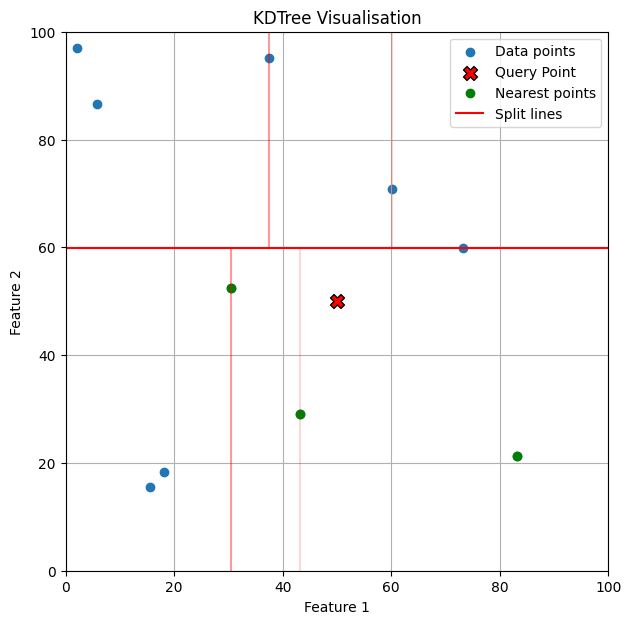

In [31]:
np.random.seed(42)
data = np.random.rand(10, 2) * 100
kdtree = KDTree(data, leaf_size=2) 
visualize_kdtree(kdtree, data, np.array([50, 50]), 3)

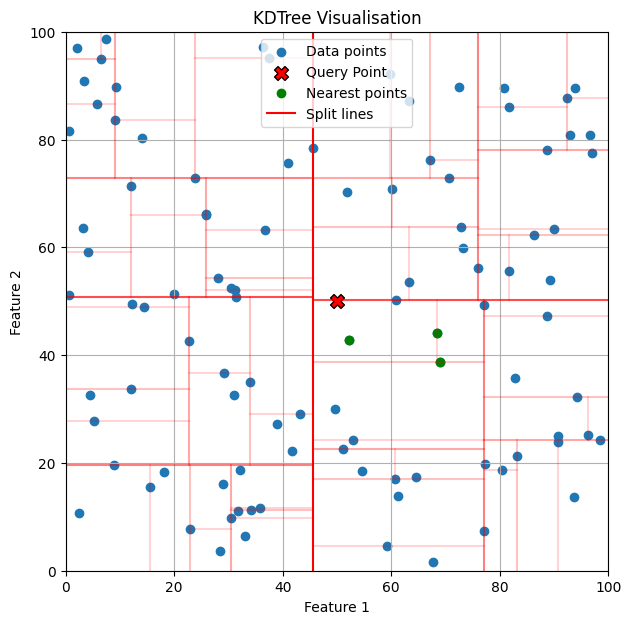

In [32]:
np.random.seed(42)
data = np.random.rand(100, 2) * 100
kdtree = KDTree(data, leaf_size=2)
q = np.array([50, 50])
k = 3
visualize_kdtree(kdtree, data, q, k, a=0.7)

In [33]:
# https://medium.com/@vidvath7/efficient-knn-search-with-locality-sensitive-hashing-a3c1b5faef4a
class LSH:
	def __init__(self, data, num_proj=10):
		self.data = np.concatenate([np.ones(data.shape[0]).reshape(-1, 1), data], axis=1)
		self.num_proj = num_proj
		self.proj = np.random.rand(num_proj, self.data.shape[1]) * 2 - 1
		self.hashes = self.get_hash(self.data)
		self.clusters = {}

		for i in range(self.data.shape[0]):
			hash = self.hashes[i].tobytes()
			if hash not in self.clusters:
				self.clusters[hash] = []
			self.clusters[hash].append(np.concatenate([self.data[i], [i]]))

		for key, val in self.clusters.items():
			self.clusters[key] = np.array(val)
  
	def get_hash(self, data):
		hash = []
		for i in range(self.num_proj):
			proj = self.proj[i]
			proj_data = np.dot(data, proj)
			hash.append(proj_data > 0)
		return np.array(hash).T
	
	def query(self, x, k=1):
		hash = self.get_hash(np.concatenate([np.ones(1).reshape(-1, 1), x.reshape(1, -1)], axis=1))[0]

		if hash.tobytes() in self.clusters:
			cluster = np.array(self.clusters[hash.tobytes()])
			dist = np.linalg.norm(cluster[:, 1:-1] - x, axis=1)
			idx = np.argsort(dist)
			return dist[idx[:min(k, len(dist))]], cluster[idx[:min(k, len(dist))], -1]

In [34]:
def visualize_kdtree(model, data, q, k):
	plt.figure(figsize=(7, 7))
	plt.scatter(q[0], q[1], color='red', label='Query Point', edgecolor='k', s=100, marker='X')

	colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
	for i, (cluster_id, vec) in enumerate(model.clusters.items()):
		color = colours[i % len(colours)]  # Use consistent colors by cycling through the palette
		plt.scatter(vec[:, 1], vec[:, 2], color=color, alpha=0.6, edgecolor='k')
	
	dist, idx = model.query(q, k)
	plt.scatter(data[idx.astype(int), 0], data[idx.astype(int), 1], color='blue', label=f'{k} Nearest Neighbors', edgecolor='k', s=100)
	for i in range(model.num_proj):
		plt.plot([0, 1], [-model.proj[i][0] / model.proj[i][2], -(model.proj[i][1] + model.proj[i][0]) / model.proj[i][2]], 'r--', linewidth=1.5, label=f'Projection Line' if i == 0 else "")


	plt.xlabel('Feature 1')
	plt.ylabel('Feature 2')
	plt.title('LSH with Nearest Neighbors and Projection Lines')
	plt.xlim(0, 1)
	plt.ylim(0, 1)
	plt.legend()
	plt.grid(True, linestyle='--', alpha=0.7)
	plt.show()

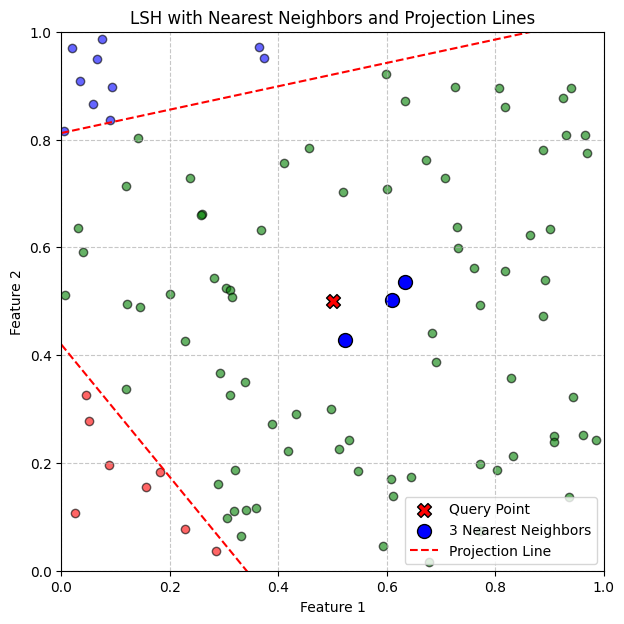

In [35]:
np.random.seed(42)
data = np.random.rand(100, 2)
lsh = LSH(data, num_proj=2)
visualize_kdtree(lsh, data, np.array([0.5, 0.5]), 3)

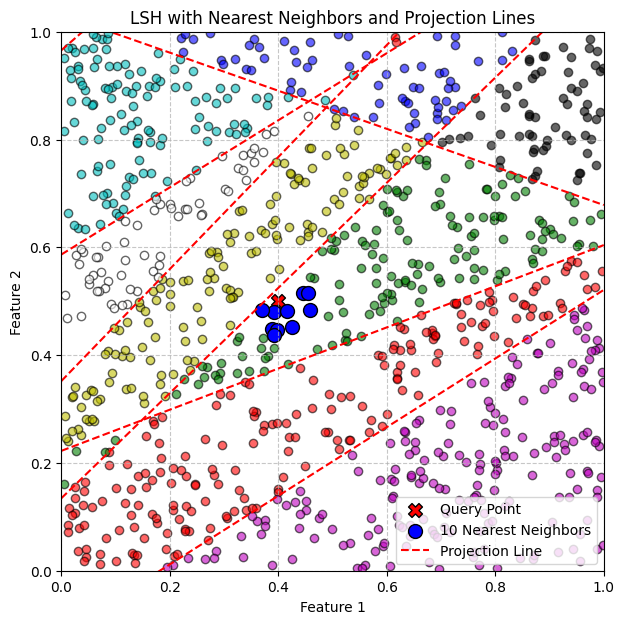

In [36]:
np.random.seed(42)
data = np.random.rand(1000, 2)
lsh = LSH(data, num_proj=10)
visualize_kdtree(lsh, data, np.array([0.4, 0.5]), 10)

In [37]:
class KNN:
	def __init__(self, data):
		self.data = data
	
	def query(self, x, k=1):
		distances = np.linalg.norm(self.data - x, axis=1)
		return np.argsort(distances)[:k]
   

In [38]:
def visualize_knn(model, data, q, k):
	plt.figure(figsize=(7, 7))
	plt.scatter(data[:, 0], data[:, 1], label='Data points')
	plt.scatter(q[0], q[1], color='red', label='Query Point', edgecolor='k', s=100, marker='X')
	
	idx = model.query(q, k)
	plt.scatter(data[idx, 0], data[idx, 1], color='blue', label=f'{k} Nearest Neighbors', edgecolor='k', s=100)

	plt.xlabel('Feature 1')
	plt.ylabel('Feature 2')
	plt.title('KNN with Nearest Neighbors')
	plt.xlim(0, 1)
	plt.ylim(0, 1)
	plt.legend()
	plt.grid(True, linestyle='--', alpha=0.7)
	plt.show()

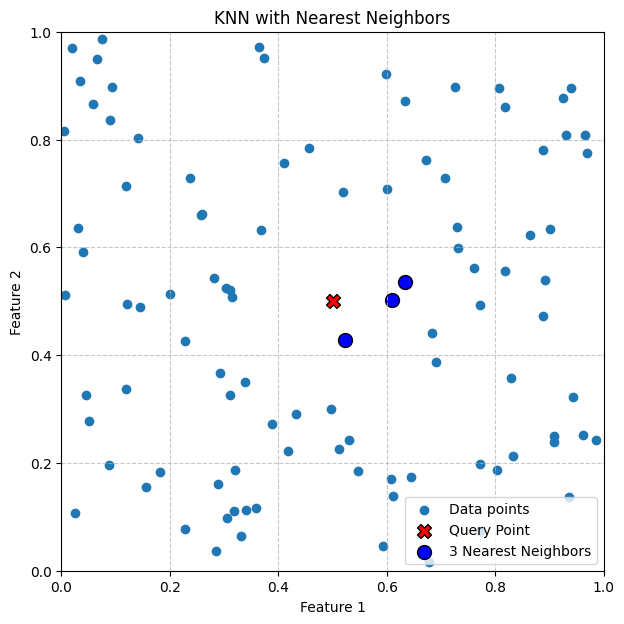

In [39]:
np.random.seed(42)
data = np.random.rand(100, 2)
knn = KNN(data)
visualize_knn(knn, data, np.array([0.5, 0.5]), 3)